In [1]:
import os
os.chdir('/Users/anthony/git-projects/midas')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from research.backtesting import BacktestLogger, FuturesBacktest, HTMLReportGenerator
from research.data_analysis import DataProcessing, TimeseriesTests
from research.strategies.cointegrationzscore.logic import Cointegrationzscore
from engine.core.base.data import Symbol, Equity, Future, Currency, Exchange
import logging


In [2]:
# Step 1 : Set data parameters
start_date = "2018-05-18"
end_date = "2023-01-19"

symbols = [
            Future(symbol="HE.n.0",currency=Currency.USD,exchange=Exchange.SMART,lastTradeDateOrContractMonth="continuous",contractSize=50,tickSize=0.25, initialMargin=4564.17),
            Future(symbol="ZC.n.0",currency=Currency.USD,exchange=Exchange.CME,lastTradeDateOrContractMonth="continuous",contractSize=50,tickSize=0.25, initialMargin=2056.75)
        ]

symbols_map = {symbol.symbol: symbol for symbol in symbols}


In [3]:
# Step 2 : Retrieve Data
data_processing = DataProcessing()
data = data_processing.get_data(list(symbols_map.keys()), start_date,end_date)


There are missing values in the DataFrame:
symbol                     HE.n.0  ZC.n.0
timestamp                                
2018-08-05 00:00:00+00:00     NaN  384.25


In [4]:
## Step 3 : Data preparation
data = data.ffill()
data_processing.check_missing(data)
# log_data = np.log(data)


No missing values in the DataFrame.


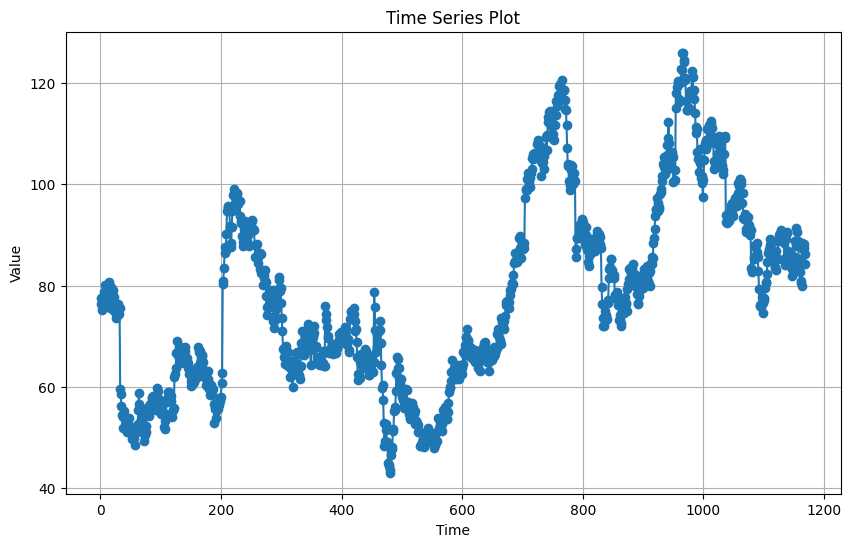

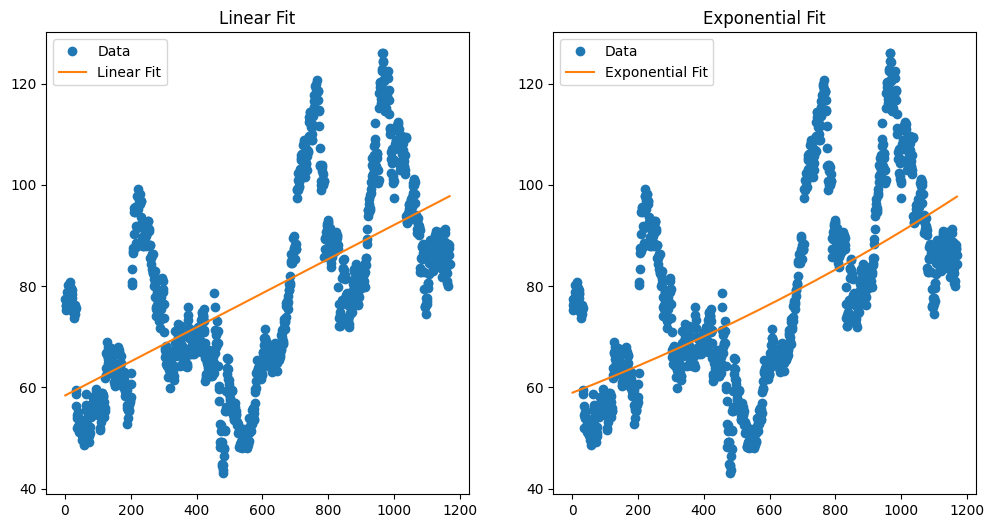

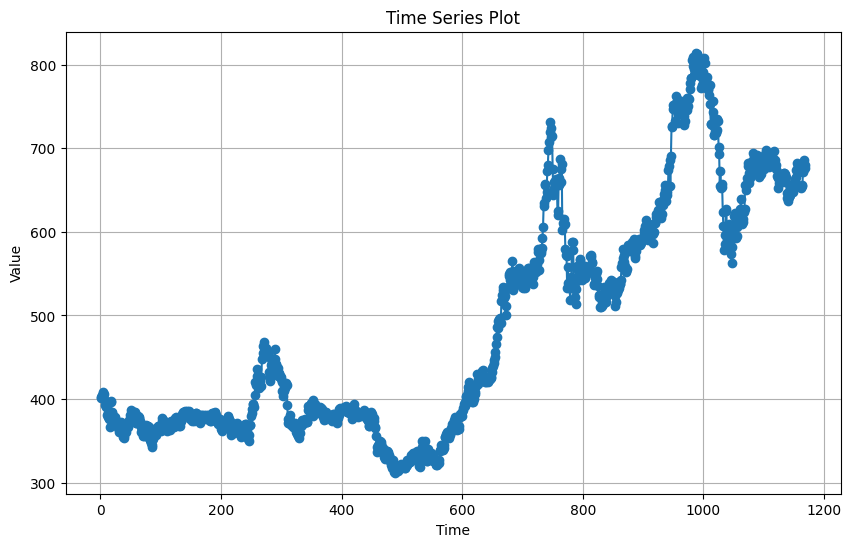

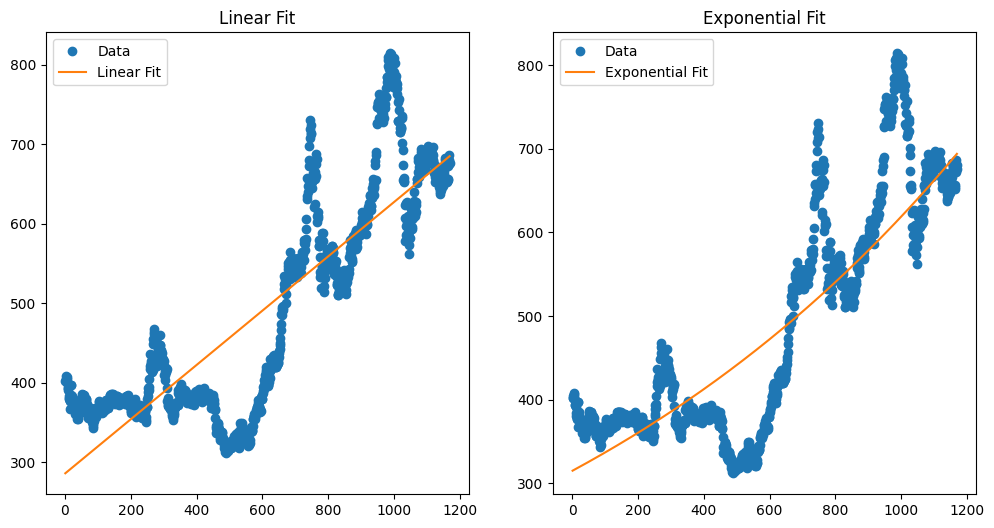

Breusch Pagan Results:
                   Ticker  Breusch-Pagan Test Statistic   p-value Heteroscedasticity
0  HE.n.0_linear_residual                     21.980127  0.000003            Present
1     HE.n.0_exp_residual                      0.005446  0.941172             Absent
2  ZC.n.0_linear_residual                    300.178396  0.000000            Present
3     ZC.n.0_exp_residual                      1.885005  0.169766             Absent
** IF p-value < 0.05, then REJECT the Null Hypothesis of homoscedasticity (constant variance) in favor of heteroscedasticity (varying variance).



In [5]:
## Step 3 : Test for exponential nature (determine if log prices will be used)
time_array = range(1, len(data) + 1)
bp_results = {}

for column in data.columns:
    value_array = data[column].values
    TimeseriesTests.line_plot(x=time_array, y=value_array)

    residuals_linear, residuals_exp = data_processing.fit_and_compare(time_array, value_array)

    bp_results[f"{column}_linear_residual"] = TimeseriesTests.breusch_pagan(np.array(residuals_linear), np.array(time_array))
    constant_to_add = abs(residuals_exp.min()) + 1

    # Adjust residuals and apply log transformation
    adjusted_residuals_exp = np.log(np.abs(residuals_exp) + constant_to_add)

    # Perform Breusch-Pagan test on adjusted residuals
    bp_results[f"{column}_exp_residual"] = TimeseriesTests.breusch_pagan(np.array(time_array), np.array(adjusted_residuals_exp))


TimeseriesTests.display_breusch_pagan_results(bp_results)



In [6]:
## Step 4 : Check stationarity
adf_results = {}
kpss_results = {}
pp_results = {}


for column in data.columns:
    series = data[column]
    adf_results[column] = TimeseriesTests.adf_test(series, trend='ct')
    pp_results[column] = TimeseriesTests.phillips_perron_test(series, trend='ct')
    # kpss_results[column] = TimeseriesTests.kpss_test(series, trend='ct')

TimeseriesTests.display_adf_results(adf_results)
TimeseriesTests.display_pp_results(pp_results)
# TimeseriesTests.display_kpss_results(kpss_results)


ADF Test Results:
   Ticker  ADF Statistic   p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%)    Stationarity
0  HE.n.0      -2.664168  0.251259            -3.966549            -3.414259             -3.129268  Non-Stationary
1  ZC.n.0      -2.942952  0.148735            -3.966698            -3.414331             -3.129311  Non-Stationary
** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).

Phillips Perron Results:
   Ticker  PP Statistic   p-value  Critical Value (1%%)  Critical Value (5%%)  Critical Value (10%%)    Stationarity
0  HE.n.0     -2.756582  0.213348             -3.966542             -3.414256              -3.129267  Non-Stationary
1  ZC.n.0     -2.532524  0.311897             -3.966542             -3.414256              -3.129267  Non-Stationary
** IF p-value < 0.05, then REJECT the Null Hypothesis of a unit root (non-stationary time series).



In [7]:
## Step 5 : Check stationarity at first difference
adf_results_diff = {}
kpss_results_diff = {}
pp_results_diff = {}

for column in data.columns:
    series = data[column].diff(1)
    series.dropna(inplace=True)
    adf_results_diff[f"{column}_diff"] = TimeseriesTests.adf_test(series)
    pp_results_diff[f"{column}_diff"] = TimeseriesTests.phillips_perron_test(series, trend='ct')
    # kpss_results_diff[f"{column}_diff"] = TimeseriesTests.kpss_test(series)

TimeseriesTests.display_adf_results(adf_results_diff)
TimeseriesTests.display_pp_results(pp_results_diff)
# TimeseriesTests.display_kpss_results(kpss_results_diff)

ADF Test Results:
        Ticker  ADF Statistic   p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationarity
0  HE.n.0_diff     -32.672131  0.000000            -3.435966            -2.864020             -2.568090   Stationary
1  ZC.n.0_diff      -5.605242  0.000001            -3.436074            -2.864068             -2.568116   Stationary
** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).

Phillips Perron Results:
        Ticker  PP Statistic  p-value  Critical Value (1%%)  Critical Value (5%%)  Critical Value (10%%) Stationarity
0  HE.n.0_diff    -32.639404      0.0             -3.966549             -3.414259              -3.129268   Stationary
1  ZC.n.0_diff    -35.114203      0.0             -3.966549             -3.414259              -3.129268   Stationary
** IF p-value < 0.05, then REJECT the Null Hypothesis of a unit root (non-stationary time series).


In [8]:
## Step 6 : Check seasonality
seasonal_adf_results = {}

for column in data.columns:
    series = data[column]
    seasonal_adf_results[f"{column}_seasonality"] = TimeseriesTests.seasonal_adf_test(series)

TimeseriesTests.display_adf_results(seasonal_adf_results)

ADF Test Results:
               Ticker  ADF Statistic  p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationarity
0  HE.n.0_seasonality     -12.007404      0.0            -3.436114            -2.864085             -2.568125   Stationary
1  ZC.n.0_seasonality     -10.134599      0.0            -3.436130            -2.864092             -2.568129   Stationary
** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).



In [9]:
## Step 7 : Check granger causality (Use differenced data as it needs to be stationary)
data_diff = data.diff(1).dropna()
granger_results = TimeseriesTests.granger_causality(data_diff, max_lag=4)
TimeseriesTests.display_granger_results(granger_results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1122  , p=0.7377  , df_denom=1164, df_num=1
ssr based chi2 test:   chi2=0.1125  , p=0.7373  , df=1
likelihood ratio test: chi2=0.1125  , p=0.7373  , df=1
parameter F test:         F=0.1122  , p=0.7377  , df_denom=1164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1005  , p=0.9044  , df_denom=1161, df_num=2
ssr based chi2 test:   chi2=0.2019  , p=0.9040  , df=2
likelihood ratio test: chi2=0.2019  , p=0.9040  , df=2
parameter F test:         F=0.1005  , p=0.9044  , df_denom=1161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2130  , p=0.8874  , df_denom=1158, df_num=3
ssr based chi2 test:   chi2=0.6429  , p=0.8866  , df=3
likelihood ratio test: chi2=0.6427  , p=0.8866  , df=3
parameter F test:         F=0.2130  , p=0.8874  , df_denom=1158, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5011  , p=0.

In [10]:

# class CointegrationStrategy(BaseStrategy):
#     def __init__(self, symbols_map:Dict[str, Symbol], logger):
#         # super().__init__()
#         self.last_signal = None  # 0: no position, 1: long, -1: short
#         self.trade_id = 1
#         self.historical_data = None
#         self.historical_spread = []
#         self.historical_zscore = []
#         self.current_zscore = None
#         self.cointegration_vector = None
#         self.hedge_ratio = {}
#         self.symbols_map = symbols_map
#         self.logger = logger

#     def reset(self):
#         """
#         Resets the strategy's state for a new test phase while preserving the training data spread.
#         """
#         self.last_signal = None
#         self.trade_id = 1
#         self.current_zscore = None

#     def prepare(self, train_data: pd.DataFrame):
#         self.historical_data = train_data
#         self.cointegration(train_data)
#         self.historic_spread(train_data)
#         self.historic_zscore()
#         symbols = train_data.columns.tolist()
#         self.asset_allocation(symbols, self.cointegration_vector)

#     def cointegration(self,train_data:pd.DataFrame):
#         # Determine Lag Length
#         lag = TimeseriesTests.select_lag_length(data=train_data)
#         self.logger.info(f"\nIdeal Lag : {lag}")

#         # Check Cointegration Relationship
#         johansen_results, num_cointegrations = TimeseriesTests.johansen_test(data=train_data, k_ar_diff=lag-1)
#         self.logger.info(TimeseriesTests.display_johansen_results(johansen_results, num_cointegrations, False))

#         self.cointegration_vector = johansen_results['Cointegrating Vector'][0]
#         self.logger.info(f"Cointegration Vector :{self.cointegration_vector}")

#     def historic_spread(self, train_data: pd.DataFrame):
#         new_spread = train_data.dot(self.cointegration_vector)
#         self.historical_spread = new_spread.tolist()

#     def update_spread(self, new_data: pd.DataFrame):
#         self.historical_spread.append(new_data.dot(self.cointegration_vector))
#         # self.test_spread.append(new_spread_value.item())  

#     def historic_zscore(self, lookback_period=None):
#         self.historical_zscore = []

#         for end_index in range(1, len(self.historical_spread) + 1):
#             if lookback_period:
#                 start_index = max(0, end_index - lookback_period)
#                 spread_lookback = self.historical_spread[start_index:end_index]
#             else:
#                 spread_lookback = self.historical_spread[:end_index]

#             z_score = self.calculate_single_zscore(spread_lookback)
#             self.historical_zscore.append(z_score)

#     def calculate_single_zscore(self, spread_lookback):
#         if len(spread_lookback) < 2:
#             return 0
#         mean = np.mean(spread_lookback)
#         std = np.std(spread_lookback)
#         return (spread_lookback[-1] - mean) / std if std != 0 else 0
    
#     def update_zscore(self,lookback_period=None):
#         # Determine the lookback range for the z-score calculation
#         spread_lookback = self.historical_spread[-lookback_period:] if lookback_period else self.historical_spread

#         # Calculate and append the new z-score
#         self.current_zscore = self.calculate_single_zscore(spread_lookback)
#         self.historical_zscore.append(self.current_zscore)

#     def data_validation(self, report_generator: HTMLReportGenerator=None):
#         # Test Stationarity in Spread
#         adf_spread_results = TimeseriesTests.adf_test(self.historical_spread)
#         pp_spread_results = TimeseriesTests.phillips_perron_test(self.historical_spread)

#         # Test historical nature of spread w/ Hurst Exponent
#         hurst_exponent_result = TimeseriesTests.hurst_exponent(self.historical_spread)
        
#         # Test historical half-life (expected time to mean revert)
#         spread_series = pd.Series(self.historical_spread)
#         spread_lagged = DataProcessing.lag_series(spread_series)
#         spread_combined = pd.DataFrame({'Original': spread_series, 'Lagged': spread_lagged}).dropna()
#         half_life, residuals = TimeseriesTests.half_life(Y = spread_combined['Original'], Y_lagged = spread_combined['Lagged'])

#         if report_generator:
#             html_content = TimeseriesTests.display_adf_results({'spread': adf_spread_results}, False, True)
#             report_generator.add_html(html_content)  
            
#             html_content = TimeseriesTests.display_pp_results({'spread': pp_spread_results}, False, True)
#             report_generator.add_html(html_content)  

#             report_generator.add_summary({'Hurst Exponent': {hurst_exponent_result}})
#             report_generator.add_summary({'Half-Life': {half_life}})
#             report_generator.add_image(TimeseriesTests.plot_price_and_spread, price_data=self.historical_data, spread=pd.Series(self.historical_zscore), show_plot=False)

#         else:
#             # Log the results if no HTML report generator is provided
#             self.logger.info(TimeseriesTests.display_adf_results({'spread': adf_spread_results}, False))
#             self.logger.info(TimeseriesTests.display_pp_results({'spread': pp_spread_results}, False))
#             self.logger.info(f"\nHurst Exponent: {hurst_exponent_result}")
#             self.logger.info(f"\nHalf-Life: {half_life}")
#             TimeseriesTests.plot_price_and_spread(price_data=self.historical_data, spread=pd.Series(self.historical_zscore))
    
#     def asset_allocation(self,symbols:list, cointegration_vector:np.array):
#         """
#         Create a dictionary of hedge ratios for each ticker.

#         Parameters:
#             data (pd.DataFrame): DataFrame containing the data with columns as tickers.
#             cointegration_vector (list): List representing the cointegration vector (hedge ratios).

#         Returns:
#             dict: Dictionary with tickers as keys and hedge ratios as values.
#         """

#         normalized_cointegration_vector = cointegration_vector / np.sum(np.abs(cointegration_vector))

#         # Ensure the length of cointegration_vector matches the number of symbols
#         if len(normalized_cointegration_vector) != len(symbols):
#             raise ValueError("Length of normalized cointegration vector must match the number of symbols.")

#             hedge_ratios = {}
        
#         # # Ensure the length of cointegration_vector matches the number of columns in data
#         # if len(cointegration_vector) != len(symbols):
#         #     raise ValueError("Length of cointegration vector must match the number of symbols.")

#         # Populate the dictionary with symbols and corresponding hedge ratios
#         # Create a dictionary of symbols and corresponding normalized hedge ratios
#         hedge_ratios = {symbol: ratio for symbol, ratio in zip(symbols, normalized_cointegration_vector)}

#         self.hedge_ratio = hedge_ratios

#     def entry_signal(self, z_score: float, entry_threshold: float):
#         if z_score > entry_threshold: # overvalued
#             self.last_signal = Direction.SHORT
#             self.logger.info(f"Entry signal z_score : {z_score} // entry_threshold : {entry_threshold} // direction : {self.last_signal}")
#             return True
#         elif z_score < -entry_threshold:
#             self.last_signal = Direction.LONG
#             self.logger.info(f"Entry signal z_score : {z_score} // entry_threshold : {entry_threshold} // direction : {self.last_signal}")
#             return True
#         return False

#     def exit_signal(self, z_score: float, exit_threshold: float):
#         if self.last_signal == Direction.LONG and z_score >= exit_threshold:
#             self.last_signal = Direction.SELL
#             self.logger.info(f"Exit signal z_score : {z_score} // entry_threshold : {exit_threshold} // action : {self.last_signal}")
#             return True
#         elif self.last_signal == Direction.SHORT and z_score <= -exit_threshold:
#             self.last_signal = Direction.COVER
#             self.logger.info(f"Exit signal z_score : {z_score} // entry_threshold : {exit_threshold} // action : {self.last_signal}")
#             return True
#         return False
    
#     def generate_trade_instructions(self, direction):
#         trade_instructions = []
#         leg_id = 1

#         for ticker, hedge_ratio in self.hedge_ratio.items():
#             # Determine the direction for each ticker based on the overall direction and hedge ratio
#             if ((direction == Direction.LONG or direction == Direction.COVER) and hedge_ratio > 0) or ((direction == Direction.SHORT or direction == Direction.SELL) and hedge_ratio < 0):
#                 hedge_ratio = abs(hedge_ratio)
#             else:
#                 hedge_ratio = -1 * abs(hedge_ratio)

#             trade_instructions.append(TradeInstruction(self.symbols_map[ticker].contract, direction, self.trade_id, leg_id, hedge_ratio))
#             leg_id += 1
            
#         return trade_instructions 
    
#     def handle_market_data(self, data, entry_threshold: float, exit_threshold: float):
#         self.update_spread(data)
#         self.update_zscore()

#         if self.exit_signal(self.current_zscore, exit_threshold):
#             trade_instructions = self.generate_trade_instructions(self.last_signal)  # Reset position to 0
#             self.trade_id += 1
#             self.last_signal = None
#             return trade_instructions 
#         elif self.entry_signal(self.current_zscore, entry_threshold):
#             return self.generate_trade_instructions(self.last_signal)

#         return None
    

In [11]:

strategy_name = "cointegrationzscore"

# Instantiate the BacktestLogger
logger = BacktestLogger(strategy_name).logger

# Report Generator
report_generator = HTMLReportGenerator(strategy_name)

# Strategy
strategy = Cointegrationzscore(symbols_map,logger)

# Backtest
backtest = FuturesBacktest(strategy, symbols_map, full_data=data, trade_allocation=0.20, logger=logger, report_generator=report_generator)

# Parameters to be sensitized 
entry_thresholds = np.arange(0.5, 1.5, 0.5)  # Example range for entry
exit_thresholds = np.arange(0.5, 2.5, 0.5)  # Example range for exit

# Walk forward-analysis
backtest.walk_forward_analysis(total_segments=3, entry_thresholds=entry_thresholds, exit_thresholds=[0.0])
report_generator.complete_report()


/Users/anthony/git-projects/midas/research/data_analysis/timeseries_analysis.py:837: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = model.params[-1]  # Get the AR coefficient (last parameter)


{(0.5, 0.0): {'Total Return(%)': 5.437726289208622, 'Sharpe Ratio': -1.9963860068234722, 'Max Drawdown(%)': -8.062}, (1.0, 0.0): {'Total Return(%)': 0.0, 'Sharpe Ratio': 0, 'Max Drawdown(%)': 0.0}}


/Users/anthony/git-projects/midas/research/data_analysis/timeseries_analysis.py:837: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = model.params[-1]  # Get the AR coefficient (last parameter)


{(0.5, 0.0): {'Total Return(%)': -99.9999314762901, 'Sharpe Ratio': -0.5520708340052931, 'Max Drawdown(%)': -99.9999}, (1.0, 0.0): {'Total Return(%)': -92.30156101050666, 'Sharpe Ratio': -0.5934875949406175, 'Max Drawdown(%)': -93.5728}}


/Users/anthony/git-projects/midas/research/data_analysis/timeseries_analysis.py:837: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = model.params[-1]  # Get the AR coefficient (last parameter)


{(0.5, 0.0): {'Total Return(%)': -17.93836921660428, 'Sharpe Ratio': -1.389054162946364, 'Max Drawdown(%)': -45.8434}, (1.0, 0.0): {'Total Return(%)': -17.938369107462993, 'Sharpe Ratio': -1.3890541788854531, 'Max Drawdown(%)': -45.8434}}


In [12]:
# jupyter nbconvert --to pdf 'core/strategies/commodity_cointegration/research.ipynb'

